In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import torch
from scipy.spatial import cKDTree
import optax
from flax import nnx
from optax import adam
from tqdm.notebook import tqdm # progress bar
import matplotlib.pyplot as plt

In [8]:
%run Data_sampling.ipynb

In [25]:
data = data_to_neighborhood(200)

Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from .

In [2]:
from sklearn.model_selection import train_test_split    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
data = np.loadtxt("../Gradient NN/Data/Training_data/THEdataset.txt")

In [ ]:
X = data[:,6:-1]
y = data[:,-1]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply feature scalin
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)


(61802, 7)

In [9]:
import pandas as pd

# Compute variance of each feature
feature_variance = X.var()

# Display features with very low variance
low_variance_features = feature_variance[feature_variance < 1e-6]
print("Low variance features:", low_variance_features)


Low variance features: []


In [26]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax

class PointCloudPredictor(nnx.Module):
    def __init__(self, input_dim: int, hidden_dim: int, *, rngs: nnx.Rngs):
        """Predictor model for step lengths based on point cloud gradients and distances."""
        self.linear1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dim, hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(hidden_dim, hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(hidden_dim, hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(hidden_dim, 1, rngs=rngs)  # Output: Scalar step length

    def __call__(self, inputs):
        """Forward pass: inputs shape = (batch_size, input_dim)"""
        x = jax.nn.relu(self.linear1(inputs))
        x = jax.nn.relu(self.linear2(x))
        x = jax.nn.relu(self.linear3(x))
        x = jax.nn.relu(self.linear4(x))
        return jax.nn.relu(self.linear5(x))  # Scalar output per point

# Initialize model
input_dim = 7  # We have 4 input features per point
hidden_dim = 64  # Can be adjusted based on complexity
rngs = nnx.Rngs(params=0)
model = PointCloudPredictor(input_dim, hidden_dim, rngs=rngs)


In [11]:
print("JAX is using device:", jax.devices())

JAX is using device: [CudaDevice(id=0)]


In [27]:
# Define loss function
def loss_fn(model, X, y):
    """Computes the Mean Squared Error (MSE) loss."""
    y_pred = model(X)  # Get predictions from the model
    return jnp.mean((y_pred - y) ** 2)  # MSE formula


# Define optimizer
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate=1e-3, weight_decay=1e-5))

# Training step
@nnx.jit
def train_step(model, optimizer, X, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, X, y)
    optimizer.update(grads)
    return loss

losses = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    loss = train_step(model, optimizer, X_train, y_train)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

Epoch 0, Loss: 0.573634
Epoch 100, Loss: 0.065198
Epoch 200, Loss: 0.062878
Epoch 300, Loss: 0.062642
Epoch 400, Loss: 0.062569
Epoch 500, Loss: 0.062529
Epoch 600, Loss: 0.062518
Epoch 700, Loss: 0.062488
Epoch 800, Loss: 0.062477
Epoch 900, Loss: 0.062470


In [24]:
from sklearn.metrics import r2_score

R^2 Score: -0.002004


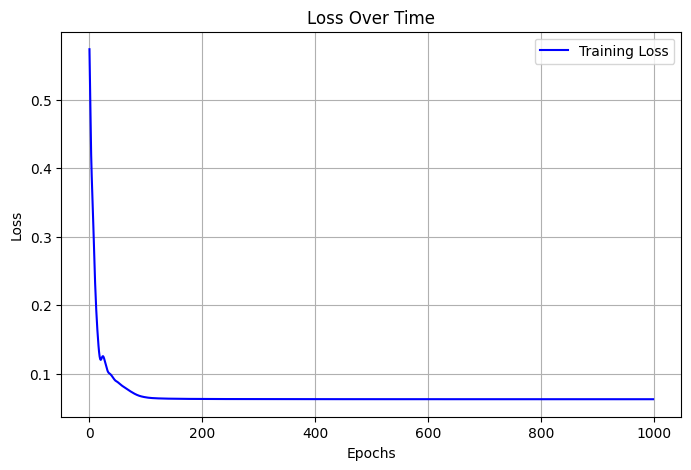

In [28]:
X_np = np.array(X_test)
y_np = np.array(y_test)

# Get model predictions
y_pred = np.array(model(X_test))

# Compute R² Score
r2 = r2_score(y_np, y_pred)
print(f"R^2 Score: {r2:.6f}")

# Plot Loss Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()